In [5]:
from rivgraph.classes import river
from rivgraph.ordered_set import OrderedSet
from rivgraph import im_utils as iu
import matplotlib.pyplot as plt
from rivgraph.classes import rivnetwork
from rivgraph import mask_to_graph as m2g
from rivgraph.rivers import river_utils as ru
from rivgraph import geo_utils as gu
import os
from datetime import datetime
import csv
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, Polygon
from rivgraph import ln_utils as lnu
from rivgraph import io_utils as io
import networkx as nx
from scipy.ndimage import distance_transform_edt
import glob
import rivgraph
print(rivgraph.__path__)


['c:\\Users\\Feifei\\mambaforge\\envs\\rivgraph\\lib\\site-packages\\rivgraph-0.5.0-py3.8.egg\\rivgraph']


### 1. load water mask and plot

In [1]:
river_name = 'Irrawaddy_Katha'  

---------- New Run ----------


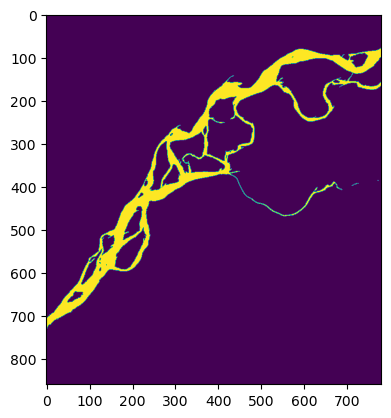

In [21]:
name = river_name.split('_')[0]

# Define the path to the georeferenced binary image.
mask_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results\{}\{}_cropped.tif".format(river_name, name)

# Where to store RivGraph-generated geotiff and geovector files.
results_folder = r'C:\Users\Feifei\Box\BR_remote_sensing\ebi_results\{}\rivgraph'.format(river_name)

# Set the exit sides of the river relative to the image. 
es = 'EW' # The first character is the upstream side
River = river(name, mask_path, results_folder, exit_sides=es, verbose=True) 
plt.imshow(River.Imask)

### 2. Remove small holes and non-river water bodies from water mask

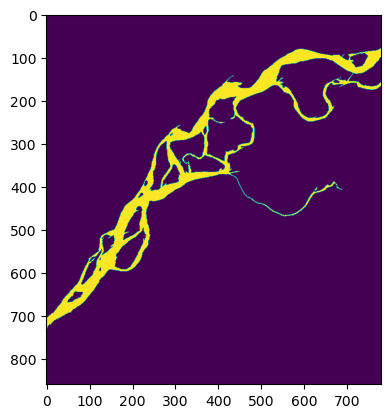

In [22]:
# Fill small holes in the mask
River.Imask=iu.fill_holes(River.Imask, maxholesize=7) # max hole size determined by channel thread width divided by 2
River.Imask=iu.largest_blobs(River.Imask, nlargest=1, action='keep')
#River.Imask, pads = m2g.cap_river_im(River.Imask, es, capsize=5)
#River.compute_network()
#River.prune_network()
#River.compute_link_width_and_length()
#River.to_geovectors('network', ftype='json')  

plt.imshow(River.Imask)
#io.write_geotiff(River.Imask, River.gt, River.wkt, r"C:\Users\Feifei\Box\BR_remote_sensing\figures\parana ", dtype=gdal.GDT_UInt16,
                  #options=['COMPRESS=LZW'])

### 3. Calculate centerline
##### This code is taken directly from rivgraph main code but rewritten by me to fix weird edge effects that were happening with rivers that had multiple channels at the exit sides

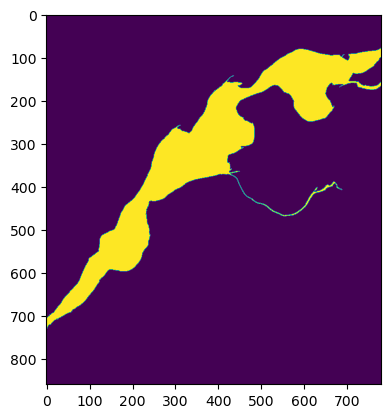

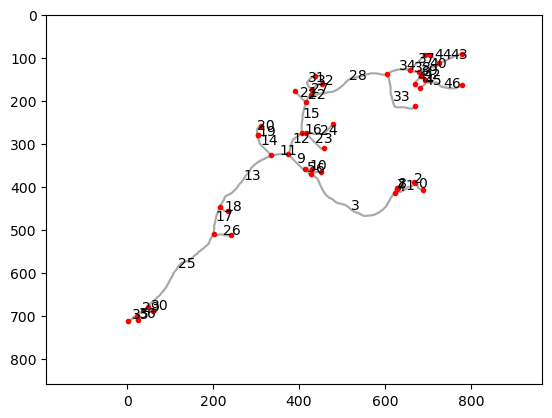

In [23]:

es = es.lower()
# Keep only largest connected blob
I = iu.largest_blobs(River.Imask, nlargest=1, action='keep')
# Fill holes in mask
Ihf = iu.fill_holes(I)
plt.imshow(Ihf)
# Skeletonize holes-filled river image
Ihf_skel = m2g.skeletonize_river_mask(Ihf, es)

# In some cases, skeleton spurs can prevent the creation of an endpoint
# at the edge of the image. This next block of code tries to condition
# # the skeleton to prevent this from happening.
# Find skeleton border pixels
skel_rows, skel_cols = np.where(Ihf_skel)
idcs_top = np.where(skel_rows == 0)
idcs_bottom = np.where(skel_rows == Ihf_skel.shape[0]-1)
idcs_right = np.where(skel_cols == Ihf_skel.shape[1]-1)
idcs_left = np.where(skel_cols == 0)
# Remove skeleton border pixels
Ihf_skel[skel_rows[idcs_top], skel_cols[idcs_top]] = 0
Ihf_skel[skel_rows[idcs_bottom], skel_cols[idcs_bottom]] = 0
Ihf_skel[skel_rows[idcs_right], skel_cols[idcs_right]] = 0
Ihf_skel[skel_rows[idcs_left], skel_cols[idcs_left]] = 0

# Remove all pixels now disconnected from the main skeleton
Ihf_skel = iu.largest_blobs(Ihf_skel, nlargest=1, action='keep')
# Add the border pixels back
Ihf_skel[skel_rows[idcs_top], skel_cols[idcs_top]] = 1
Ihf_skel[skel_rows[idcs_bottom], skel_cols[idcs_bottom]] = 1
Ihf_skel[skel_rows[idcs_right], skel_cols[idcs_right]] = 1
Ihf_skel[skel_rows[idcs_left], skel_cols[idcs_left]] = 1

# Keep only the largest connected skeleton
Ihf_skel = iu.largest_blobs(Ihf_skel, nlargest=1, action='keep')
# Convert skeleton to graph
hf_links, hf_nodes = m2g.skel_to_graph(Ihf_skel)
lnu.plot_network(hf_links, hf_nodes, Ihf_skel, label_links=True, label_nodes=False)
# Compute holes-filled distance transform
Ihf_dist = distance_transform_edt(Ihf)  # distance transform

# Append link widths and lengths
hf_links = lnu.link_widths_and_lengths(hf_links, Ihf_dist)

# Find shortest path between inlet/outlet centerline nodes
# Put skeleton into networkX graph object
G = nx.Graph()
G.add_nodes_from(hf_nodes['id'])
for lc, wt in zip(hf_links['conn'], hf_links['len']):
    G.add_edge(lc[0], lc[1], weight=wt)

# Get endpoints of graph
endpoints = [nid for nid, nconn in zip(hf_nodes['id'], hf_nodes['conn']) if len(nconn) == 1]

# Filter endpoints if we have too many--shortest path compute time scales as a power of len(endpoints)
while len(endpoints) > 100:
    ep_r, ep_c = np.unravel_index([hf_nodes['idx'][hf_nodes['id'].index(ep)] for ep in endpoints], Ihf_skel.shape)
    pct = 10
    ep_keep = set()
    for esi in [0, 1]:
        if es[esi] == 'n':
            n_pct = int(np.percentile(ep_r, pct))
            ep_keep.update(np.where(ep_r <= n_pct)[0])
        elif es[esi] == 's':
            s_pct = int(np.percentile(ep_r, 100-pct))
            ep_keep.update(np.where(ep_r >= s_pct)[0])
        elif es[esi] == 'e':
            e_pct = int(np.percentile(ep_c, 100-pct))
            ep_keep.update(np.where(ep_c > e_pct)[0])
        elif es[esi] == 'w':
            w_pct = int(np.percentile(ep_c, pct))
            ep_keep.update(np.where(ep_c < w_pct)[0])

    endpoints = [endpoints[ek] for ek in ep_keep]

# Convert endpoint indices to row and column coordinates
ep_r, ep_c = np.unravel_index([hf_nodes['idx'][hf_nodes['id'].index(ep)] for ep in endpoints], Ihf_skel.shape)

# Handle the first direction in 'es'
first_direction = es[0]
if first_direction == 'n':
    min_r, min_r_idx = np.min(ep_r), np.argmin(ep_r)
    end_nodes = [endpoints[min_r_idx]]
elif first_direction == 's':
    max_r, max_r_idx = np.max(ep_r), np.argmax(ep_r)
    end_nodes = [endpoints[max_r_idx]]
elif first_direction == 'e':
    max_c, max_c_idx = np.max(ep_c), np.argmax(ep_c)
    end_nodes = [endpoints[max_c_idx]]
elif first_direction == 'w':
    min_c, min_c_idx = np.min(ep_c), np.argmin(ep_c)
    end_nodes = [endpoints[min_c_idx]]

# Handle the last direction in 'es'
last_direction = es[-1]
if last_direction == 'n':
    min_r, min_r_idx = np.min(ep_r), np.argmin(ep_r)
    end_nodes.append(endpoints[min_r_idx])
elif last_direction == 's':
    max_r, max_r_idx = np.max(ep_r), np.argmax(ep_r)
    end_nodes.append(endpoints[max_r_idx])
elif last_direction == 'e':
    max_c, max_c_idx = np.max(ep_c), np.argmax(ep_c)
    end_nodes.append(endpoints[max_c_idx])
elif last_direction == 'w':
    min_c, min_c_idx = np.min(ep_c), np.argmin(ep_c)
    end_nodes.append(endpoints[min_c_idx])

# Ensure that exactly two end nodes are identified
if len(end_nodes) != 2:
    raise RuntimeError('{} endpoints were found for the centerline. (Need exactly two).'.format(len(end_nodes)))


# Find upstream node
en_r, en_c = np.unravel_index([hf_nodes['idx'][hf_nodes['id'].index(n)] for n in end_nodes], Ihf_skel.shape)

# Compute error for each end node given the exit sides
errors = []
for orientation in [0, 1]:
    if orientation == 0:
        er = en_r
        ec = en_c
    elif orientation == 1:
        er = en_r[::-1]
        ec = en_c[::-1]

    err = 0
    for ot in [0, 1]:
        if es[ot].lower() == 'n':
            err = err + er[ot]
        elif es[ot].lower() == 's':
            err = err + Ihf_dist.shape[0] - er[ot]
        elif es[ot].lower() == 'w':
            err = err + ec[ot]
        elif es[ot].lower() == 'e':
            err = err + Ihf_dist.shape[1] - ec[ot]
    errors.append(err)
# Flip end node orientation to get US->DS arrangement
if errors[0] > errors[1]:
    end_nodes = end_nodes[::-1]

# Create centerline from links along shortest path
nodespath = nx.dijkstra_path(G, end_nodes[0], end_nodes[1])  # nodes shortest path
# Find the links along the shortest node path
cl_link_ids = []
for u, v in zip(nodespath[0:-1], nodespath[1:]):
    ulinks = hf_nodes['conn'][hf_nodes['id'].index(u)]
    vlinks = hf_nodes['conn'][hf_nodes['id'].index(v)]
    cl_link_ids.append([ul for ul in ulinks if ul in vlinks][0])

# Create a shortest-path links dict
cl_links = dict.fromkeys(hf_links.keys())
dokeys = list(hf_links.keys())
dokeys.remove('n_networks')  # Don't need n_networks
for clid in cl_link_ids:
    for k in dokeys:
        if cl_links[k] is None:
            cl_links[k] = []
        cl_links[k].append(hf_links[k][hf_links['id'].index(clid)])

# Get and save coordinates of centerline
cl = []
for ic, cll in enumerate(cl_link_ids):
    if ic == 0:
        if hf_links['idx'][hf_links['id'].index(cll)][0] != hf_nodes['idx'][hf_nodes['id'].index(end_nodes[0])]:
            hf_links['idx'][hf_links['id'].index(cll)] = hf_links['idx'][hf_links['id'].index(cll)][::-1]
    else:
        if hf_links['idx'][hf_links['id'].index(cll)][0] != cl[-1]:
            hf_links['idx'][hf_links['id'].index(cll)] = hf_links['idx'][hf_links['id'].index(cll)][::-1]

    cl.extend(hf_links['idx'][hf_links['id'].index(cll)][:])
    
# Uniquify points, preserving order
cl = list(OrderedSet(cl))

# Convert back to coordinates
cly, clx = np.unravel_index(cl, Ihf_skel.shape)

# Get width at each pixel of centerline
pix_width = [Ihf_dist[y, x]*2 for x, y in zip(clx, cly)]

coords = np.transpose(np.vstack((clx, cly)))

#save centerline
River.centerline = gu.xy_to_coords(coords[:,0], coords[:,1], River.gt)
River.to_geovectors('centerline', ftype='json')

### 4. Calculate mesh

In [27]:
River.compute_mesh(buf_halfwidth=9000, smoothing=1.2, grid_spacing=2000, single_thread=False)
River.to_geovectors('centerline', ftype='json')
River.to_geovectors('mesh', ftype='json')

Generating mesh...
Multilinestring returned in offset_linestring; clipped to longest but check output.
mesh generation is done.


In [29]:
# json_pattern = os.path.join(results_folder, '*.json')

# # Use glob to find all matching JSON files
# json_files = glob.glob(json_pattern)

# # Iterate over the list of JSON files and remove each one
# for json_file in json_files:
#     try:
#         os.remove(json_file)
#     except Exception as e:
#         print(f'Failed to delete {json_file}. Reason: {e}')